# Weighted coin

In [1]:
using Gen
using PyPlot

## Model

In [2]:
@gen function coin_tosses(n_tosses)
    
    p = @trace(beta(10.0, 10.0), :prob)
    
    for i=1:n_tosses
        toss = @trace(bernoulli(p), :z => i)
    end
    
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any], ##coin_tosses#371, Bool[0], false)

## Data

In [3]:
hidden_p = 0.61
n_tosses = 100
dataset = [bernoulli(hidden_p) for i=1:n_tosses];

## Exact Prior; Exact Posterior

In [4]:
p_space = 0.0:0.005:1.0
exact_prior = map(x -> exp(logpdf(beta, x, 10.0, 10.0)), p_space);

In [16]:
n_pos = sum(dataset)
n_neg = n_tosses - n_pos
println("number of (heads, tails): (", n_pos, ", ", n_neg, ")")
exact_posterior = map(x -> exp(logpdf(beta, x, 10.0 + n_pos, 10.0 + n_neg)), p_space);

number of (heads, tails): (58, 42)


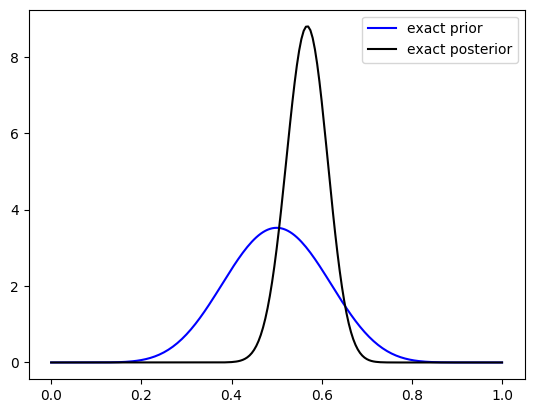

In [6]:
function plot_exact()
    plot(p_space, exact_prior, color="blue", label="exact prior")
    plot(p_space, exact_posterior, color="black", label="exact posterior")
end

plot_exact()
legend()
show()

## Sampling from the posterior: importance resampling

In [7]:
observations = Gen.choicemap()
for i=1:n_tosses
    observations[:z => i] = dataset[i]
end
    
n_posterior_samples = 1000
posterior_samples = zeros(n_posterior_samples) 

for j=1:n_posterior_samples
    tr, _ = Gen.importance_resampling(coin_tosses, (n_tosses,), observations, 40)
    posterior_samples[j] = tr[:prob]
end

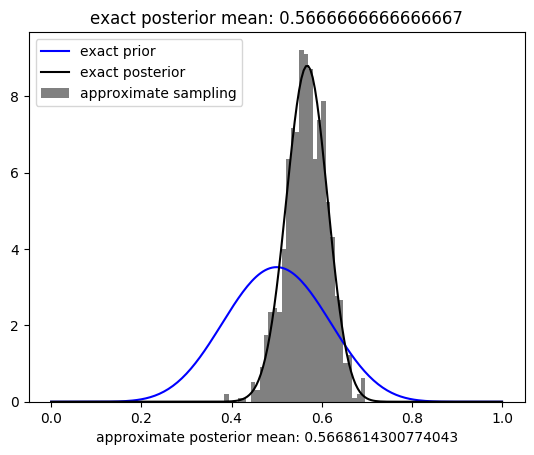

In [8]:
using Statistics


function plot_sample_approx(samples)
    plot_exact()
    hist(samples, color="gray", bins=Int(round(sqrt(n_posterior_samples))), density=true, label="approximate sampling")
    title("exact posterior mean: $((10.0 + n_pos)/(20.0 + n_tosses))")
    xlabel("approximate posterior mean: $(mean(posterior_samples))")
end

plot_sample_approx(posterior_samples)
legend()
show()

## Sampling from the posterior: Metropolis-Hastings

In [9]:
# Define a proposal distribution: 
# we resample from a beta centered at the current value.
@gen function p_proposal(cur_tr)

    #z = inv_sigmoid(cur_tr[:prob])
    #dz = normal(0, 0.25)
    #x = sigmoid(z + dz)
    strength = 30.0
    @trace(beta(strength*cur_tr[:prob], strength*(1 - cur_tr[:prob])), :prob)

end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any], ##p_proposal#372, Bool[0], false)

In [10]:
function mh_sample(tr, n_samples=1000, burnin=200, thinning=10)
    
    probs = zeros(n_samples)
    
    for b=1:burnin
        (tr, _) = Gen.mh(tr, p_proposal, ()) 
    end
    
    for i=1:n_samples
        for t=1:thinning
            (tr, _) = Gen.mh(tr, p_proposal ,()) 
        end
        
        probs[i] = tr[:prob]
    end
    
    return probs
end

mh_sample (generic function with 4 methods)

In [11]:
# Get an initial trace
observations = Gen.choicemap()
for i=1:n_tosses
    observations[:z => i] = dataset[i]
end
(initial_trace, _) = Gen.generate(coin_tosses, (n_tosses,), observations);

In [12]:
# Use MCMC to get a posterior sample
p_sample_mh = mh_sample(initial_trace);

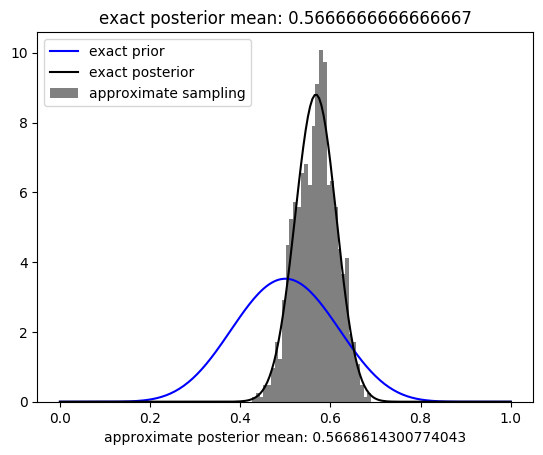

In [13]:
plot_sample_approx(p_sample_mh)
legend()
show()